# Module 4.2: Ordinary Differential Equations (Runge-Kutta Method)

Today, we'll learn about a better differential equation solver, and how not to reinvent the wheel.

## Learning objectives:
* Better algorithms > faster computers
* Write a slightly more complex algorithm
* Practice using external libraries

# Pre-class

Download the PDF of [TAK](https://catalog.lib.ncsu.edu/record/NCSU4441969) and read Sec 7.2. You will probably find it helpful to read along using a paper/pencil, and/or be able to draw on your PDF.

Read through the module below, to familiarize yourself with the day's work. There is a lot of mathematical notation here, so come to class to prepared to ask questions about what you don't understand.

# In class

## Second order Runge-Kutta

Recall that a system of ordinary differential equations (ODE’s) can be written as
$$
\frac{du}{dt} = f (u, t)
$$
The vector of dependent variables is denoted $u$, and the independent variable is $t$. The right–hand side, $f(u,t)$, is a vector of functions of the dependent and independent variables. 

For the Euler method, we approximate the ODE’s at time $t = t_i \equiv i\Delta t$ by 
$$
\frac{du}{dt}\approx (u_{i+1} - u_i)/\Delta t = f(u_i,t_i)\Delta t,
$$
where $u_i \equiv u(t_i)$. Rearranging, we have the result
$$
u_{i+1} =u_i +f(u_i,t_i) \Delta t
$$
which allows us to solve for $u_{i+1}$ given $u_i$. 

The Taylor series expansion of $u(t_i + \Delta t)$ shows that the exact result is
$$
u_{i+1} =u_i +f(u_i,t_i)\Delta t+\mathcal{O}(\Delta t^2)
$$
where $\mathcal{O}(\Delta t^2)$ denotes terms of order  t2. Thus, each step of the Euler method introduces truncation errors proportional to $\Delta t^2$. Since the number of timesteps required to reach a finite time is proportional to $1/\Delta t$, the cumulative error in the Euler method is order $\Delta t$. We say that the Euler method is a _first order_ method, meaning that the errors are proportional to the first power of $\Delta t$.

Go back and look at your plots of error vs `dt` to confirm for yourself that this is the case.

The second order Runge–Kutta method (RK2) is defined by the following two–substep process:
$$
\begin{aligned}
u_h &= u_i +f(u_i,t_i)\Delta t/2 \\
u_{i+1} &= u_i +f(u_h,t_h)\Delta t
\end{aligned}
$$
where $t_h \equiv t_i +  \Delta t/2$. In the first substep, the Euler method is used to estimate the value of $u$ at the half timestep. That is, the value of $u$ at time $t_h \equiv t_i + \Delta t/2$. Here, this value is denoted $u_h$; sometimes it is denoted $u_{i+1/2}$. The second substep looks just like the Euler method, but instead of using $u_i$ and $t_i$ in the function $f$, we use the half–timestep values $u_h$ and $t_h$.

__This algorithm identically reproduces the second order term in the Taylor expansion of $u(t+\Delta t)$.  Thus, the error goes as $\Delta t^2$!__

## Exercise

Implement the RK2 solver in the code below.

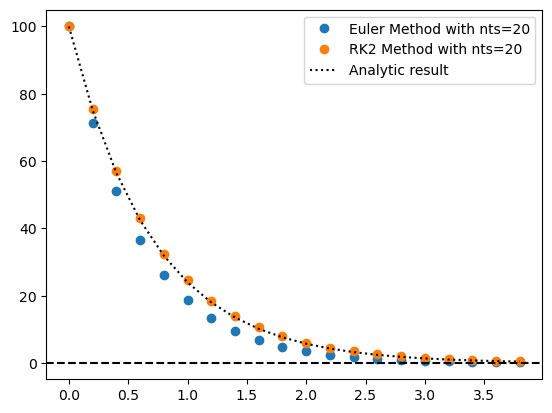

In [89]:
import numpy as np
import pylab as p

tau = 0.7        # mean lifetime, in gigayears
N0 = 100.0 # initial number of nuclei

tmin = 0.0
tmax = 4.0

nts=20

# Create an array to hold the times
t_array = np.linspace(tmin, tmax, nts, endpoint=False)  
dt = t_array[1] - t_array[0]  #  This is an easy way to define dt that is not error prone

# Empty array to hold the number of nuclei
N_array = np.zeros( len(t_array) )

# Empty array for Euler comparison
N_euler = np.zeros( len(t_array) )


# Do the simple Euler solution
# Set the initial condition
N_euler[0] = N0
for it in range(0, len(t_array)-1 ):
    N_euler[it+1] = N_euler[it] + dt * (-1./tau * N_euler[it])
    
# The above should have been familiar from Module 6.1

# Do the RK2 solution
N_array[0] = N0
for it in range(0, len(t_array)-1 ):
    t  = t_array[it]         # Don't necessarily need it but nice to have a simpler named variable
    th = t_array[it] + dt/2  # Note: we don't need this for this particular ODE
    
    N_h           = N_array[it] + dt * 0.5 * (-1./tau * N_array[it]) # FILL THIS IN
    N_array[it+1] = N_array[it] + dt * (-1./tau * N_h) # FILL THIS IN
    
    
# Make a plot (note the label for the curve)
p.plot(t_array, N_euler, 'o', label="Euler Method with nts="+str(nts))
p.plot(t_array, N_array, 'o', label="RK2 Method with nts="+str(nts))
p.plot(t_array, N0*np.exp(-t_array/tau),'k:',label="Analytic result")

# Add a legend (based on the labels)
p.legend()

# Add a horizontal axis
p.axhline(0.0, color='k', linestyle='--')

# Show the plot
p.show()

A more usable differential equation solver
------------------------------
We’ve now used the Euler/RK2 methods to solve a few differential equations, and have probably either re-written the code or copied it previously. However, we can do better! We can re-write the code in a way that makes it usable for a variety of problems without changing the differential equation solver.  Consider the Euler solver we've been using:


In [90]:
import numpy as np
import pylab as p

tau = 0.7        # mean lifetime
N0 = 100.0       # initial number of nuclei
tmin = 0.0       # start time
tmax = 4.0       # end time
nts=20           # number of points

# Create an array to hold the times and number of nuclei
t = np.linspace(tmin, tmax, nts + 1)  
N = np.zeros( len(t_array) )

dt = t[1] - t[0]  #  This is an easy way to define dt that is not error prone

# Do the simple Euler solution
N[0] = N0
for it in range(0, len(t) - 2 ):
    N[it+1] = N[it] + dt* (-1./tau * N[it])


We can re-write the solver in its own function, and then pass in a separate function that knows how to compute the right hand side of the equation (the derivative):

Shapes: (6,) (6,)


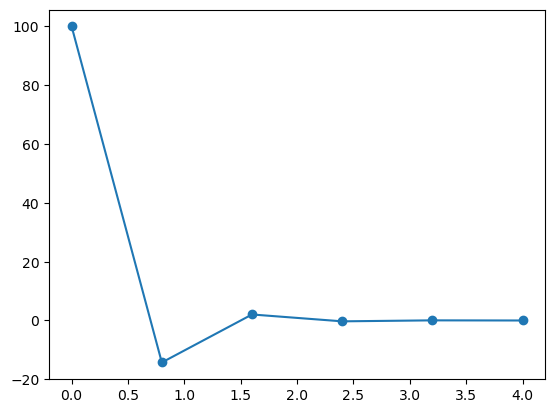

In [91]:
import numpy as np
import pylab as p

# This function calculates the RHS of the differential equation
# for the decay problem: just -(1/tau) * N
def decay_deriv(N,t):
    # The derivative in principle may depend on N and t -- in this
    # case, it only depends on N
    return -(1./tau) * N

# This function runs an Euler solver.  We have to tell it the initial
# value, the min/max time range, the number of time points,
# and how to compute the derivative (we pass in a function
# for this).
def Euler_solver(N_initial, tmin, tmax, nts, deriv):
    N = np.zeros(nts+1)
    t = np.linspace(tmin, tmax, nts+1)
    
    # Note: a way of defining dt that is less error-prone
    dt = t[1] - t[0]
    N[0] = N_initial
    for it in range(0,nts):
        N[it+1] = N[it] + dt * deriv(N[it], t[it])
    return t, N

tau = 0.7        # mean lifetime
N0 = 100.0       # initial number of nuclei
tmin = 0.0       # start time
tmax = 4.0       # end time
nts=5           # number of points

t,N_euler = Euler_solver(N0, tmin, tmax, nts, decay_deriv)

# I wonder what these things are?  Let's look at their shapes.
print ("Shapes:",np.shape(t), np.shape(N_euler))

p.plot(t,N_euler,'o-')
p.show()

## Digging in deeper 

Let's dissect the code above a little bit.  We've defined a few functions, we'll get to those in a minute.  Below those, we find the initial value (`N0`), the time axis parameters (`tmin, tmax, nts`) and the physics (`tau`). After that, we find this line:

    t,N_euler = Euler_solver(N0, tmin, tmax, nts, decay_deriv)
    
This calls the `Euler_solver` function with a bunch of parameters, and assigns the return values (__note there are two return values__) to the `t` and `N_euler` variables.  We won't _a priori_ know what they are, but we can check with a call to `shape()`.  It turns out these are length-21 arrays -- that kind of makes sense since that's what I expect from an Euler solver. (Note, I could have written it so that it takes a t array as input as well).  

As the last argument, we are passing in `decay_deriv`.  This is the name of the function that, given $N(t)$ and $t$, knows how to compute the derivative (i.e. it has the right hand side of the ODE in it).

Within `Euler_solver`, we find the usual, now-familiar setup for an Euler solver.  One line is somewhat different:

    N[it+1] = N[it] + dt * deriv(N[it], t[it])
    
In the past, we had the explicit form of the derivative for the nuclear decay problem at the end of that line.  Now, instead, we'll call yet another function which will compute it for us.  Just like the right hand side of a general ODE, it takes the function (here $N(t)$ and the independent variable $t$).

Since we passed `decay_deriv` in to the variable `deriv` of the `Euler_solver` function, that's what will be called to compute the derivative.

All of this structure is useful for a few things
1. Replacing the derivative function without having to rewrite the whole code
2. Understanding how to use better, pre-written differential equation solvers (next section)

## Homework 4.2

a) Well-commented code which uses your RK2 solver to compute the relative error at the last time point for at least four different resolutions (`nts`).

b) Make a plot of log10(error) vs log10(nts), and explain how this shows that the relative errors are proportional to $\Delta t^2$.

c) Compute the relative error in your RK2 code when the number of time steps is set to `nts=100`. Use your Euler code to find the (approximate) number of time steps required for Euler to give a result with comparable error.   

Error for nts = 10: 0.5610254275593622
Error for nts = 20: 0.1511075171841436
Error for nts = 30: 0.08488756348609233
Error for nts = 40: 0.05876584815375191
Error for nts = 50: 0.04488039608679317
Error for nts = 60: 0.036284390298002844
Error for nts = 70: 0.03044465819902631
Error for nts = 80: 0.026220746782734394
Error for nts = 90: 0.023024397276880715
Error for nts = 100: 0.020521716983206484


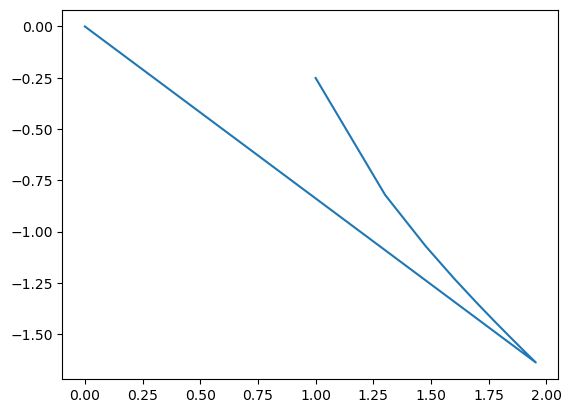

In [92]:
#HW 4.2
#RK2 Solver

# tau = 0.7        # mean lifetime, in gigayears
# N0 = 100.0 # initial number of nuclei

# tmin = 0.0
# tmax = 4.0

# nts=20

# define RK2 solver fcn
def rk2(tau, N0, tmin, tmax, nts):

    t_array = np.linspace(tmin, tmax, nts, endpoint=False)  
    dt = t_array[1] - t_array[0]  #  This is an easy way to define dt that is not error prone

    N_array = np.zeros( len(t_array) )
    N_array[0] = N0

    for i in range(0, len(t_array) - 1):

        N_h = N_array[i] + dt * 0.5 * (-1./tau * N_array[i])
        N_array[i+1] = N_array[i] + dt * (-1./tau * N_h)

    return N_array

print('Error for nts = 10:', rk2(0.7, 100.0, 0.0, 4.0, 10)[-1] - (100.0*np.exp(-4.0/0.7)))
print('Error for nts = 20:', rk2(0.7, 100.0, 0.0, 4.0, 20)[-1] - (100.0*np.exp(-4.0/0.7)))
print('Error for nts = 30:', rk2(0.7, 100.0, 0.0, 4.0, 30)[-1] - (100.0*np.exp(-4.0/0.7)))
print('Error for nts = 40:', rk2(0.7, 100.0, 0.0, 4.0, 40)[-1] - (100.0*np.exp(-4.0/0.7)))
print('Error for nts = 50:', rk2(0.7, 100.0, 0.0, 4.0, 50)[-1] - (100.0*np.exp(-4.0/0.7)))
print('Error for nts = 60:', rk2(0.7, 100.0, 0.0, 4.0, 60)[-1] - (100.0*np.exp(-4.0/0.7)))
print('Error for nts = 70:', rk2(0.7, 100.0, 0.0, 4.0, 70)[-1] - (100.0*np.exp(-4.0/0.7)))
print('Error for nts = 80:', rk2(0.7, 100.0, 0.0, 4.0, 80)[-1] - (100.0*np.exp(-4.0/0.7)))
print('Error for nts = 90:', rk2(0.7, 100.0, 0.0, 4.0, 90)[-1] - (100.0*np.exp(-4.0/0.7)))
print('Error for nts = 100:', rk2(0.7, 100.0, 0.0, 4.0, 100)[-1] - (100.0*np.exp(-4.0/0.7)))

err_array = np.zeros(10)
nts_array = np.zeros(10)
for i in range(9):
    err_array[i] = np.log10(rk2(0.7, 100.0, 0.0, 4.0, (i+1)*10)[-1] - (100.0*np.exp(-4.0/0.7)))
    nts_array[i] = np.log10((i+1)*10)

p.plot(nts_array, err_array)
p.show()
# t_array = np.linspace(0.0, 4.0, 20, endpoint=False)
# p.plot(t_array, rk2(0.7, 100.0, 0.0, 4.0, 20))
# p.plot(t_array, N0*np.exp(-t_array/tau),'k:',label="Analytic result")
# p.show()

## Homework 4.3

Write a similar function as `Euler_solver` called `RK2_solver` that takes the same arguments and returns the same values. It should use the RK2 algorithm to do the differential equation solving. (Hint: it should only require the addition of a line or two.)

Your uploaded code will just be the function `RK2_solver`

This will be manually-graded, not autograded, but needs to run correctly inside the notebook. If everything is working, the correct plot will appear for me to grade quickly and give you full credit!

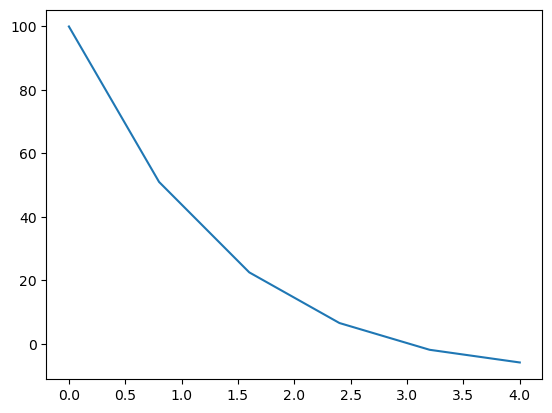

In [93]:
#HW4.3

def RK2_solver(N_initial, tmin, tmax, nts, deriv):
    N = np.zeros(nts+1)
    t = np.linspace(tmin, tmax, nts+1)
    
    # Note: a way of defining dt that is less error-prone
    dt = t[1] - t[0]
    N[0] = N_initial
    for it in range(0,nts):
        N_h = N_array[it] + dt * 0.5 * deriv(N[it], t[it])
        N[it+1] = N_array[it] + dt * deriv(N_h, t[it])
    return t, N

t, N_RK2 = RK2_solver(100.0, 0.0, 4.0, 5, decay_deriv)
p.plot(t, N_RK2)
p.show()

Someone else's differential equation solver
============================
There are quite a few ways of solving differential equations that are more complex (and more accurate) than both Euler and RK2 (for example, RK4). Fortunately for us, most of these have already been coded up, and we can simply call them rather than writing each and every one ourselves. Numpy doesn’t have any of these, but Scipy does. __Scipy__ is a large repository of scientific computing code, with many things already implemented, including differential equation solvers. Here, we will use odeint, which stands for Ordinary Differential Equation Integrator. You may find the documentation here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html. 

Have a look at the documentation, and the example at the bottom of the page. You’ll find that it takes about a million possible arguments, but only three are necessary: the function that computes the derivative, the initial value, and the time axis. We could thus define a function that looks like our Euler/RK2 solvers that calls the scipy integrator as follows:

    # We need to make sure that the code has access to the odeint function
    # so we import it
    from scipy.integrate import odeint
    def diffeq_solver_from_scipy(N_initial, tmin, tmax, nts, deriv):
        t = np.linspace(tmin, tmax, nts)
        
        # Note that the order of arguments matches the documentation
        N = odeint(deriv, N_initial, t)
        
        return t,N
        
Note the similarity to the code we wrote above in the `Euler_solver` function.  This was intentional -- this way, you should be able to simply exchange one function call for another.

_Scipy_ by default uses something called the Adams method for differential equation solving.

## Homework 4.4

a) Write additional code to use the scipy `odeint` integrator to solve the nuclear decay problem. Please use the same parameters we've been using, with `nts=5`. 

b) Make a well-labelled plot comparing the analytic solution, SciPy odeint result,  RK2 result, and Euler result (all for `nts=5`).

c) Comment on the accuracy and precision of the these three differential equation solvers, including pros/cons.

d) How is scipy achieving its improved performance?

*Hint:* This HW is not as long as it looks! You already have a function that computes each of the three solutions.  All you have to do is put these in one piece of code, call and plot them one by one. Your writeup does not need to repeat code already written for earlier problems, just the new parts.

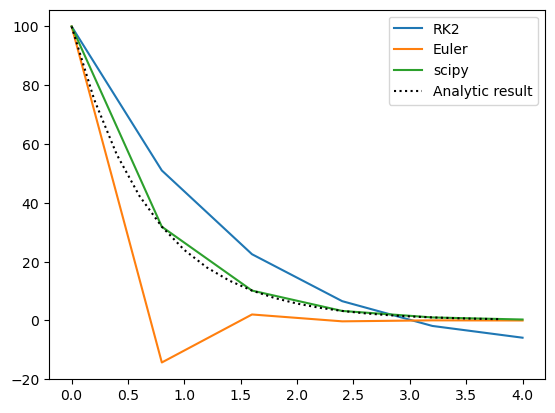

In [94]:
#HW 4.4

from scipy.integrate import odeint
def diffeq_solver_from_scipy(N_initial, tmin, tmax, nts, deriv):
    t = np.linspace(tmin, tmax, nts)
    N = odeint(deriv, N_initial, t)
    return N

N_scipy = diffeq_solver_from_scipy(100.0, 0.0, 4.0, 6, decay_deriv)
# print(N_euler, N_scipy, N_RK2)
p.plot(t, N_RK2, label ='RK2')
p.plot(t, N_euler, label = 'Euler')
p.plot(t, np.reshape(N_scipy, (-1,)), label = 'scipy')
p.plot(t_array, N0*np.exp(-t_array/tau),'k:',label="Analytic result")

p.legend()
p.show()

The RK2 and scipy results are very close to the analytic solution at high nts, but for nts 5 scipy is the closest.

# Post-class

Between now and the next class meeting: finish the rest of the module on your own.

# Acknowledgements
This workbook is from K.E. Daniels's _Introduction to Scientific Computing_ at NCSU